##  Car Price Prediction - Preprocessing

###  Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import re
import pprint
import joblib

#Python iterators for efficient looping
import itertools

#transformers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

#pd.set_option('max_colwidth', 2000)
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

### Import Raw Data

In [2]:
#Import data - austin, dallas, houston, and san antonio.  Two snapshots.

austin1=pd.read_json('json/austin_ford_2019-11-18.json')
dallas1=pd.read_json('json/dallas_ford_2019-11-18.json')
ep1=pd.read_json('json/ep_ford_2019-11-18.json')
houston1=pd.read_json('json/houston_ford_2019-11-18.json')
sa1=pd.read_json('json/sa_ford_2019_11_18.json')

austin2=pd.read_json('json/austin_ford_2019-12-29.json')
dallas2=pd.read_json('json/dallas_ford_2019-12-29.json')
ep2=pd.read_json('json/ep_ford_2019-12-29.json')
houston2=pd.read_json('json/houston_ford_2019-12-29.json')
sa2=pd.read_json('json/sa_ford_2019_11_18.json')

vehicle = pd.DataFrame()
for dframe in [austin1, dallas1, ep1, houston1, sa1, austin2, dallas2, ep2, houston2, sa2]:
    vehicle = vehicle.append(dframe, ignore_index = True)
display(f'vehicle has {len(vehicle)} rows:', vehicle.tail(1))

'vehicle has 21080 rows:'

,URL_Vehicle,Title,Price,SubLoc,Body,AttribDictionary,ImageDictionary
21079,https://sanantonio.craigslist.org/ctd/d/san-an...,2008 FORD F250 SUPER DUTY CREW CAB,$16900,(1200 basse rd San Antonio TX),"[\n , \n2008 FORD F250 SUPER DUTY CREW ...",{'0': '<span><b>2008 ford f-250 super duty cre...,{'0': 'https://images.craigslist.org/00k0k_9Lu...


In [3]:
#The vehicle 'Body' is a comma-delimited list.  Join list into a single string.
vehicle['Body'] = vehicle['Body'].str.join(',')

#Remove whitespace.  Replace NaNs with None.
vehicle['SubLoc'] = vehicle['SubLoc'].str.strip()
SubLoc_dict={'SubLoc': {np.nan : 'None'}}
vehicle.replace(SubLoc_dict, inplace=True)

In [4]:
#Add feature columns and view dataframe
print('vehicle length:', len(vehicle))
print('vehicle type:', type(vehicle))

vehicle.insert(2,'Location',np.nan)
vehicle.insert(3,'Year',np.nan)
vehicle.insert(4,'Year_in_Title',np.nan)
vehicle.insert(5,'Odometer',np.nan)
vehicle.insert(6,'RawMake',np.nan)
vehicle.insert(7,'Make',np.nan)
vehicle.insert(8,'Model',np.nan)
vehicle.insert(9,'Trim',np.nan)
vehicle.insert(10,'Seller',np.nan)
vehicle.head(1)

vehicle length: 21080
vehicle type: <class 'pandas.core.frame.DataFrame'>


,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary
0,https://austin.craigslist.org/ctd/d/temple-201...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCAL...","{'0': '<span><b>2016 FORD</b></span>', '1': '<...",{'0': 'https://images.craigslist.org/00505_1T8...


In [5]:
def match_regex_patt(df, target_col, regex_patt, no_match_value='None'):
    '''Returns regex_patt matches as list.  Case is ignored.'''
    matchList=[]
    cnt = 0
    for idx in df.index:
        m = re.search(regex_patt, df.loc[idx, target_col], flags=re.IGNORECASE) #re.search(pattern, string) gets first match
        if m is not None:
            matchList.append(m.group(1).lower())
        else:
            cnt+=1
            matchList.append(no_match_value)
    print(f'In {target_col}, {cnt} missed matches for regex pattern: {regex_patt}.')
    return matchList

In [6]:
def findall_regex_patt(df, target_col, regex_patt, no_match_value='None'):
    '''Returns regex_patt matches found left-to-right as list.  Case is ignored.'''
    findallList=[]
    cnt = 0
    for idx in df.index:
        allm = re.findall(regex_patt, df.loc[idx, target_col] + " ", flags=re.IGNORECASE) #return all matches left-to-right
        allm = allm[0:2]  #first two items
        oneString = ("").join(allm).strip() #convert list to string and remove any spaces.
        if len(oneString) > 0:
            findallList.append(oneString.lower())
        else:
            cnt+=1
            findallList.append(no_match_value)
    print(f'In {target_col}, {cnt} missed matches for regex pattern: {regex_patt}.')
    return findallList

In [7]:
#Get VehicleID from URL_Vehicle.    
vehIDList = match_regex_patt(df=vehicle, target_col='URL_Vehicle', regex_patt=r'/(\d+)\.html', no_match_value='None')    
vehicle['VehicleID'] = vehIDList

#Get vehicle Location from URL location.craigslist.org
vehLocList = match_regex_patt(df=vehicle, target_col='URL_Vehicle', regex_patt='https://(.+)\.craigslist', no_match_value='None')    
vehicle['Location'] = vehLocList

In URL_Vehicle, 0 missed matches for regex pattern: /(\d+)\.html.
In URL_Vehicle, 0 missed matches for regex pattern: https://(.+)\.craigslist.


In [8]:
pd.set_option('max_colwidth', 80)
vehicle.head(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID
0,https://austin.craigslist.org/ctd/d/temple-2016-ford-f350-xlt-67l-diesel/702...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS! NEW 35"" MTs TX TRUCK!",austin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCALL OR TEXT 254-247-2172,\n,\n20...","{'0': '<span><b>2016 FORD</b></span>', '1': '<span>fuel: <b>gas</b></span>',...","{'0': 'https://images.craigslist.org/00505_1T8mOTcvOy7_600x450.jpg', '1': 'h...",7022706459
1,https://austin.craigslist.org/cto/d/red-rock-2006-ford-focus-se/7022331083.html,2006 Ford Focus SE,austin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$3000,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanical condition-AC/Heater work gr...","{'0': '<span><b>2006 Ford Focus SE</b></span>', '1': '<span>fuel: <b>gas</b>...","{'0': 'https://images.craigslist.org/00n0n_dXTq6r46TL4_600x450.jpg', '1': 'h...",7022331083


In [9]:
vehicle['AttribDictionary']

0        {'0': '<span><b>2016 FORD</b></span>', '1': '<span>fuel: <b>gas</b></span>',...
1        {'0': '<span><b>2006 Ford Focus SE</b></span>', '1': '<span>fuel: <b>gas</b>...
2        {'0': '<span><b>2004 FORD F450</b></span>', '1': '<span>condition: <b>excell...
3        {'0': '<span><b>2007 FORD E350 SHUTTLE BUS</b></span>', '1': '<span>conditio...
4        {'0': '<span><b>1979 1979 FORD MUSTANG</b></span>', '1': '<span>fuel: <b>gas...
                                              ...                                       
21075    {'0': '<span><b>2013 Ford Explorer SUV</b></span>', '1': '<span>fuel: <b>gas...
21076    {'0': '<span><b>2005 FORD E350</b></span>', '1': '<span>VIN: <b>1FBSS31S85HA...
21077    {'0': '<span><b>2014 Ford Mustang</b></span>', '1': '<span>fuel: <b>gas</b><...
21078    {'0': '<span><b>2016 FORD</b></span>', '1': '<span>fuel: <b>diesel</b></span...
21079    {'0': '<span><b>2008 ford f-250 super duty crew cab</b></span>', '1': '<span...
Name: AttribDictionar

In [10]:
#Drop incomplete listing 5247.
vehicle.drop(index = 5247, inplace = True)

In [11]:
#Build Year column from AttribDictionary.  Assert numeric format and none missing.
yrList=[]
for idx in vehicle.index:
    m = re.search(r'(\d+)', vehicle.loc[idx, 'AttribDictionary']['0'])  #re.search(pattern, string) gets first match
    yrList.append(m.group(1))  
vehicle['Year'] = yrList    
vehicle['Year'] = vehicle['Year'].astype('float').astype('int64')

#Keep Years 1995 and later.
print('Count of vehicles older than 1999 that were dropped:', sum(vehicle['Year'] < 1999))
filt = (vehicle['Year'] >= 1995)
vehicle = vehicle[filt]

assert vehicle['Year'].dtypes == 'int64',  "Year must be integer."
assert len(vehicle[vehicle['Year'].isna()]) == 0, "Year cannot have NAs."

Count of vehicles older than 1999 that were dropped: 1323


In [12]:
#Extract Odometer & VIN from AttribDictionary.  For each index, go through dict keys.
odomet=[]
vin = []
vinCNT=0

for idx in vehicle.index:
    odo_success = 0
    vin_success = 0
    
    for k in vehicle.loc[idx, 'AttribDictionary'].keys():
        od_m = re.search(r'<span>odometer: <b>(\d+)</b>', vehicle.loc[idx, 'AttribDictionary'][str(k)]) #re.search(pattern, string) gets first match
        vin_m = re.search(r'<span>VIN: <b>(\w+)</b>', vehicle.loc[idx, 'AttribDictionary'][str(k)]) #re.search(pattern, string) gets first match
                        
        if od_m is not None:
            odo_success = 1
            odomet.append(od_m.group(1))            
        if vin_m is not None:
            vin_success = 1
            vin.append(vin_m.group(1))          
            
    if odo_success != 1:
        odomet.append(np.nan)        
    if vin_success != 1:
        vinCNT += 1
        vin.append('None'+str(vinCNT))  #Assign unique value.  VIN is missing--not neccesarily duplicate listing.


vehicle['Odometer'] = odomet
vehicle['Odometer'] = vehicle['Odometer'].astype('float')
vehicle['VIN'] = vin

In [13]:
#Create final Odometer feature

#Mine Odometer alternative from Body.
odomAlt=r'((\d+,?\.?\d+)(K\s| miles))'
odomAltList = match_regex_patt(df=vehicle, target_col='Body', regex_patt=odomAlt, no_match_value=np.nan)    
vehicle['RawOdomAlt'] = odomAltList

#Clean RawOdomAlt numbers.
vehicle['RawOdomAlt'] = vehicle['RawOdomAlt'].str.replace('[Kk]', '000').str.replace(',', '')\
                        .str.replace('.', '').str.replace('miles', '').str.strip()

#Set clean numbers less than 1,000 to np.nan.  Mileage this low is likely invalid.
vehicle['OdomAlt'] = vehicle['RawOdomAlt'].astype('float')
vehicle.loc[vehicle['OdomAlt'] < 1000, 'OdomAlt'] = np.nan

#Assign the OdomAlt value to NaN Odometer values.  Drop RawOdomAlt and OdomAlt.
vehicle.loc[vehicle['Odometer'].isna(), 'Odometer'] = vehicle.loc[vehicle['Odometer'].isna(), 'OdomAlt']
vehicle.drop(['RawOdomAlt', 'OdomAlt'], axis='columns', inplace=True, errors='igonre')

#Fix odometer typo.
vehicle.loc[9196, 'Odometer'] = vehicle.loc[9196, 'Odometer'] / 1000
vehicle.loc[19738, 'Odometer'] = vehicle.loc[19738, 'Odometer'] / 1000

In Body, 12530 missed matches for regex pattern: ((\d+,?\.?\d+)(K\s| miles)).


In [14]:
#Create dealer/owner features using URL_vehicle.
vehicle['Seller']=vehicle['URL_Vehicle'].str.extract(r'(ct[o|d])')
vehicle['Seller']=vehicle['Seller'].str.replace('ctd', 'dealer')
vehicle['Seller']=vehicle['Seller'].str.replace('cto', 'owner')

### Make, Model, and Trim

In [15]:
#Extract RawMake col from AttribDictionary in UPPERCASE.
rawMakeList=[]
for idx in vehicle.index:
    m = re.search(r'<b>(.+)</b>', vehicle.loc[idx, 'AttribDictionary']['0']) #re.search(pattern, string) gets first match
    if m is not None:
        rawMakeList.append(m.group(1))
    else:
        print('Missing Make/Model index:', idx)
        rawMakeList.append('None')
                 
vehicle['RawMake'] = rawMakeList

In [16]:
vehicle.head(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN
0,https://austin.craigslist.org/ctd/d/temple-2016-ford-f350-xlt-67l-diesel/702...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS! NEW 35"" MTs TX TRUCK!",austin,2016,NaN,127.0,2016 FORD,NaN,NaN,NaN,dealer,$34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCALL OR TEXT 254-247-2172,\n,\n20...","{'0': '<span><b>2016 FORD</b></span>', '1': '<span>fuel: <b>gas</b></span>',...","{'0': 'https://images.craigslist.org/00505_1T8mOTcvOy7_600x450.jpg', '1': 'h...",7022706459,None1
1,https://austin.craigslist.org/cto/d/red-rock-2006-ford-focus-se/7022331083.html,2006 Ford Focus SE,austin,2006,NaN,181000.0,2006 Ford Focus SE,NaN,NaN,NaN,owner,$3000,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanical condition-AC/Heater work gr...","{'0': '<span><b>2006 Ford Focus SE</b></span>', '1': '<span>fuel: <b>gas</b>...","{'0': 'https://images.craigslist.org/00n0n_dXTq6r46TL4_600x450.jpg', '1': 'h...",7022331083,None2


In [17]:
#Populate Make
make_regex=r'\s(ford)'
makeList = match_regex_patt(df=vehicle, target_col='RawMake', regex_patt=make_regex, no_match_value='None')    
vehicle['Make'] = makeList

#Populate Model.
model_regex=r'(bronco|buick|caravan|cargo|cmax|c-max|contour|crown|dually|e-150|e150|e-250|e250|e-350|e350|e-450|e450|ecoline|econoline|ecosport|edge|es350|escape|escort|excursion|expedition|explorer|f-150|f-250|f-350|f-450|f-550|f-650|f-750|f-800|f150|f250|f350|f450|f550|f650|f750|f800|fiesta|five|flex|focus|freestar|freestyle|fusion|lcf|lincoln|mustang|national|ranger|raptor|regency|scion|shelby|sport|starcraft|t-150|t-250|t-350|taurus|thunderbird|transit|transit-150|transit-250|transit-350|van|windstar)'
model_RawMake = match_regex_patt(df=vehicle, target_col='RawMake', regex_patt=model_regex, no_match_value='None')    
vehicle['Model'] = model_RawMake

In RawMake, 5 missed matches for regex pattern: \s(ford).
In RawMake, 417 missed matches for regex pattern: (bronco|buick|caravan|cargo|cmax|c-max|contour|crown|dually|e-150|e150|e-250|e250|e-350|e350|e-450|e450|ecoline|econoline|ecosport|edge|es350|escape|escort|excursion|expedition|explorer|f-150|f-250|f-350|f-450|f-550|f-650|f-750|f-800|f150|f250|f350|f450|f550|f650|f750|f800|fiesta|five|flex|focus|freestar|freestyle|fusion|lcf|lincoln|mustang|national|ranger|raptor|regency|scion|shelby|sport|starcraft|t-150|t-250|t-350|taurus|thunderbird|transit|transit-150|transit-250|transit-350|van|windstar).


In [18]:
#Populate Model.
Model_Title = match_regex_patt(df=vehicle, target_col='Title', regex_patt=model_regex, no_match_value='None')
vehicle['Model_Title'] = Model_Title
vehicle.loc[vehicle['Model'] == 'None', 'Model'] = vehicle.loc[vehicle['Model'] == 'None', 'Model_Title']

#Drop redundant column
vehicle.drop(['Model_Title'], axis='columns', inplace=True)

In Title, 769 missed matches for regex pattern: (bronco|buick|caravan|cargo|cmax|c-max|contour|crown|dually|e-150|e150|e-250|e250|e-350|e350|e-450|e450|ecoline|econoline|ecosport|edge|es350|escape|escort|excursion|expedition|explorer|f-150|f-250|f-350|f-450|f-550|f-650|f-750|f-800|f150|f250|f350|f450|f550|f650|f750|f800|fiesta|five|flex|focus|freestar|freestyle|fusion|lcf|lincoln|mustang|national|ranger|raptor|regency|scion|shelby|sport|starcraft|t-150|t-250|t-350|taurus|thunderbird|transit|transit-150|transit-250|transit-350|van|windstar).


In [19]:
#Populate max two Trim from RawMake.  Case Insensitive.
trim_regex=r'\s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESEL|DIESEL|DUALLY|ENERGI|HARLEY|HYBRID|LARIAT|OUTLAW|RAPTOR|SALEEN|SHELBY|SPORTS|TREMOR|CARGO|COBRA|COUPE|EDDIE|SPORT|SUPER|TURBO|WAGON|BASE|BOSS|CREW|DUMP|KING|MACH|4+4|4X4|BOX|DRW|EXT|FWD|FX2|FX4|FX5|LTZ|MAX|SEL|SRW|STX|XLS|XLT|XL|ZX3|ZX4|GT|LX|RS|SE\s|ST|SD)'
trim_RawMake = findall_regex_patt(df=vehicle, target_col='RawMake', regex_patt=trim_regex, no_match_value='None')    
vehicle['Trim_RawMake'] = trim_RawMake

In RawMake, 13147 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESEL|DIESEL|DUALLY|ENERGI|HARLEY|HYBRID|LARIAT|OUTLAW|RAPTOR|SALEEN|SHELBY|SPORTS|TREMOR|CARGO|COBRA|COUPE|EDDIE|SPORT|SUPER|TURBO|WAGON|BASE|BOSS|CREW|DUMP|KING|MACH|4+4|4X4|BOX|DRW|EXT|FWD|FX2|FX4|FX5|LTZ|MAX|SEL|SRW|STX|XLS|XLT|XL|ZX3|ZX4|GT|LX|RS|SE\s|ST|SD).


In [20]:
#Populate max two Trim from Title.  Case Insensitive.
trim_Title = findall_regex_patt(df=vehicle, target_col='Title', regex_patt=trim_regex, no_match_value='None')    
vehicle['Trim_Title'] = trim_Title

In Title, 4344 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESEL|DIESEL|DUALLY|ENERGI|HARLEY|HYBRID|LARIAT|OUTLAW|RAPTOR|SALEEN|SHELBY|SPORTS|TREMOR|CARGO|COBRA|COUPE|EDDIE|SPORT|SUPER|TURBO|WAGON|BASE|BOSS|CREW|DUMP|KING|MACH|4+4|4X4|BOX|DRW|EXT|FWD|FX2|FX4|FX5|LTZ|MAX|SEL|SRW|STX|XLS|XLT|XL|ZX3|ZX4|GT|LX|RS|SE\s|ST|SD).


## Body Search

In [21]:
def findall_body_regex_patt(df, target_col, regex_patt, no_match_value='None'):
    '''Returns regex_patt matches found left-to-right as list.  Case is ignored.'''
    findallList=[]
    cnt = 0
    for idx in df.index:
        patt_w_model = df.loc[idx, "Model"] + regex_patt  #regex pattern is: Model + Pattern
        allm = re.findall(patt_w_model, df.loc[idx, target_col] + " ", flags=re.IGNORECASE) #return all matches left-to-right
        allm = allm[0:2]  #first two items
        oneString = ("").join(allm).strip() #convert list to string and remove any spaces.
        if len(oneString) > 0:
            findallList.append(oneString.lower())
        else:
            cnt+=1
            findallList.append(no_match_value)
    print(f'In {target_col}, {cnt} missed matches for regex pattern: {regex_patt}.')
    return findallList

In [22]:
#Populate max two Trim from Body.
trim_regex_spaces=r'\s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESEL|DIESEL|DUALLY|ENERGI|HARLEY|HYBRID|LARIAT|OUTLAW|RAPTOR|SALEEN|SHELBY|SPORTS|TREMOR|CARGO|COBRA|COUPE|EDDIE|SPORT|SUPER|TURBO|WAGON|BASE|BOSS|CREW|DUMP|KING|MACH|4+4|4X4|BOX|DRW|EXT|FWD|FX2|FX4|FX5|LTZ|MAX|SEL|SRW|STX|XLS|XLT|XL|ZX3|ZX4|GT|LX|RS|SE\s|ST|SD)\s'
trim_Body = findall_body_regex_patt(df=vehicle, target_col='Body', regex_patt=trim_regex_spaces, no_match_value='None')
vehicle['Trim_Body'] = trim_Body

In Body, 15751 missed matches for regex pattern: \s(CONVERTIBLE|COMMERCIAL|COMMERCIAL|FLARESIDE|HATCHBACK|LIGHTNING|PASSENGER|SUPER\\S?CAB|SUPER\\S?CREW|SUPER\\S?DUTY|SUPERCREW|ECOBOOST|EXTENDED|HERITAGE|PLATINUM|SUPERCAB|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESEL|DIESEL|DUALLY|ENERGI|HARLEY|HYBRID|LARIAT|OUTLAW|RAPTOR|SALEEN|SHELBY|SPORTS|TREMOR|CARGO|COBRA|COUPE|EDDIE|SPORT|SUPER|TURBO|WAGON|BASE|BOSS|CREW|DUMP|KING|MACH|4+4|4X4|BOX|DRW|EXT|FWD|FX2|FX4|FX5|LTZ|MAX|SEL|SRW|STX|XLS|XLT|XL|ZX3|ZX4|GT|LX|RS|SE\s|ST|SD)\s.


In [23]:
# pd.set_option('max_colwidth', 400)
# vehicle.loc[(vehicle['Trim_RawMake'] == 'None') & (vehicle['Trim_Title'] == 'None') & (vehicle['Trim_Body'] != 'None'),\
#             ['RawMake','Title','Trim_Body','Body']].shape

In [24]:
#Scrub Trim in order:  Trim_RawMake, Trim_Title, Trim_Body.
vehicle.loc[vehicle['Trim'].isna(), 'Trim'] = vehicle.loc[vehicle['Trim'].isna(), 'Trim_RawMake']
vehicle.loc[vehicle['Trim'] == 'None', 'Trim'] = vehicle.loc[vehicle['Trim'] == 'None', 'Trim_Title']
vehicle.loc[vehicle['Trim'] == 'None', 'Trim'] = vehicle.loc[vehicle['Trim'] == 'None', 'Trim_Body']

#Drop redundant Trim columns.
vehicle.drop(['Trim_RawMake','Trim_Title','Trim_Body'], axis='columns', inplace=True)

In [25]:
vehicle[['Trim','RawMake','Title','Body']].head(2)

,Trim,RawMake,Title,Body
0,xltdiesel,2016 FORD,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS! NEW 35"" MTs TX TRUCK!","\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCALL OR TEXT 254-247-2172,\n,\n20..."
1,se,2006 Ford Focus SE,2006 Ford Focus SE,"\n ,\n2006 Ford Focus in great mechanical condition-AC/Heater work gr..."


In [26]:
#Trim value counts.  "None" is improved.
vehicle.Trim.value_counts(dropna=False)[0:5]

None        3302
se          1256
xlt         1233
super        895
supersrw     692
Name: Trim, dtype: int64

In [27]:
#Scrub Price - remove any $, periods, and spaces.  Note:  ORDER IS IMPORTANT!
#No raw string -- use "\" to escape next character.
vehicle['Price']=vehicle['Price'].str.replace('\,', '')
vehicle['Price']=vehicle['Price'].str.replace('\.00', '')
vehicle['Price']=vehicle['Price'].str.replace('\.0', '')
vehicle['Price']=vehicle['Price'].str.replace('\$', '')
vehicle['Price']=vehicle['Price'].str.replace('-', '')
vehicle['Price']=vehicle['Price'].str.replace(' ', '')
vehicle['Price']=vehicle['Price'].str.replace('\.', 'None')

In [28]:
vehicle.head(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN
0,https://austin.craigslist.org/ctd/d/temple-2016-ford-f350-xlt-67l-diesel/702...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS! NEW 35"" MTs TX TRUCK!",austin,2016,NaN,127.0,2016 FORD,ford,f350,xltdiesel,dealer,34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCALL OR TEXT 254-247-2172,\n,\n20...","{'0': '<span><b>2016 FORD</b></span>', '1': '<span>fuel: <b>gas</b></span>',...","{'0': 'https://images.craigslist.org/00505_1T8mOTcvOy7_600x450.jpg', '1': 'h...",7022706459,None1
1,https://austin.craigslist.org/cto/d/red-rock-2006-ford-focus-se/7022331083.html,2006 Ford Focus SE,austin,2006,NaN,181000.0,2006 Ford Focus SE,ford,focus,se,owner,3000,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanical condition-AC/Heater work gr...","{'0': '<span><b>2006 Ford Focus SE</b></span>', '1': '<span>fuel: <b>gas</b>...","{'0': 'https://images.craigslist.org/00n0n_dXTq6r46TL4_600x450.jpg', '1': 'h...",7022331083,None2


In [29]:
#Insert CombMPG and displacement from modelYR.  
EPA = joblib.load('EPA.joblib')

#Backup vehicle indices before merge.
vehicle_idx_BAK = vehicle.index

#Merge data
vehicle = vehicle.merge(EPA, how='left', left_on=['Model','Year'], right_on=['clean_model','year'])

#Drop redundant columns.
vehicle.drop(columns=['clean_model', 'year'], inplace=True)
vehicle.rename(columns={'comb08' : 'CombMPG'}, inplace=True)

#Restore original vehicle indices that were reset by merge.
vehicle.index = vehicle_idx_BAK

In [30]:
vehicle.loc[9196, 'Odometer']

145360.0

In [31]:
vehicle.head(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN,displ,CombMPG
0,https://austin.craigslist.org/ctd/d/temple-2016-ford-f350-xlt-67l-diesel/702...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS! NEW 35"" MTs TX TRUCK!",austin,2016,NaN,127.0,2016 FORD,ford,f350,xltdiesel,dealer,34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCALL OR TEXT 254-247-2172,\n,\n20...","{'0': '<span><b>2016 FORD</b></span>', '1': '<span>fuel: <b>gas</b></span>',...","{'0': 'https://images.craigslist.org/00505_1T8mOTcvOy7_600x450.jpg', '1': 'h...",7022706459,None1,NaN,NaN
1,https://austin.craigslist.org/cto/d/red-rock-2006-ford-focus-se/7022331083.html,2006 Ford Focus SE,austin,2006,NaN,181000.0,2006 Ford Focus SE,ford,focus,se,owner,3000,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanical condition-AC/Heater work gr...","{'0': '<span><b>2006 Ford Focus SE</b></span>', '1': '<span>fuel: <b>gas</b>...","{'0': 'https://images.craigslist.org/00n0n_dXTq6r46TL4_600x450.jpg', '1': 'h...",7022331083,None2,2.0,25.0


In [32]:
grp = vehicle.groupby(['Model','Year','Trim']).agg({'displ' : 'median','CombMPG' : 'median'})

In [33]:
#Trim-level displ/mileage is unavailable in EPA data.  So *all* trim levels get median values.
#For example, a 2017 Mustang GT gets the same displacement as 2017 ecoboost.  More granularity will improve the model.
model_mustang = grp.copy().reset_index()
model_mustang = model_mustang[(model_mustang['Model'] == 'mustang') & (model_mustang['Year'] == 2017)]
model_mustang

,Model,Year,Trim,displ,CombMPG
3966,mustang,2017,None,3.7,21.0
3967,mustang,2017,convertible,3.7,21.0
3968,mustang,2017,coupe,3.7,21.0
3969,mustang,2017,ecoboost,3.7,21.0
3970,mustang,2017,ecoboostcoupe,3.7,21.0
3971,mustang,2017,ecoboostpremium,3.7,21.0
3972,mustang,2017,gt,3.7,21.0
3973,mustang,2017,gtconvertible,3.7,21.0
3974,mustang,2017,gtcoupe,3.7,21.0
3975,mustang,2017,gtpremium,3.7,21.0


### Drop bad rows

In [34]:
#Drop TRUCKMAX autos that are outside Texas.  
vehicle[vehicle['SubLoc'] == '(TRUCKMAX)']
drop_indices = vehicle[vehicle['SubLoc'] == '(TRUCKMAX)'].index
print(f'Drop {len(drop_indices)} TRUCKMAX listings outside Texas:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

Drop 317 TRUCKMAX listings outside Texas: Int64Index([ 1955,  2120,  2121,  2275,  2277,  2299,  2304,  2418,  2419,
             2554,
            ...
            20343, 20409, 20443, 20607, 20635, 20685, 20744, 20751, 20928,
            20937],
           dtype='int64', length=317)


In [35]:
#Price is missing, None, or blank.  Drop corresponding rows.
filt = (vehicle['Price'].isna()) | (vehicle['Price'] == 'None') | (vehicle['Price'] == '')
drop_indices = vehicle[filt].index
print(f'Drop {len(drop_indices)} missing price rows:', drop_indices, '\n')
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

#Make isn't 'ford'.  Drop corresponding rows.
filt = (vehicle['Make'] != 'ford')
drop_indices = vehicle[filt].index
print(f'Drop {len(drop_indices)} non-ford makes:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

#Price is "NoneNoneNone"
filt = (vehicle['Price'] == 'NoneNoneNone')
drop_indices = vehicle[filt].index
print(f'Drop {len(drop_indices)} bad prices:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

#Cast Price as float.
vehicle['Price'] = vehicle['Price'].astype('float')
assert len(vehicle[vehicle['Price'].isna()]) == 0, "Price cannot have NAs."

Drop 2392 missing price rows: Int64Index([   12,    15,    33,    44,    45,    46,    63,    64,    81,
               84,
            ...
            20999, 21013, 21014, 21023, 21033, 21035, 21041, 21047, 21060,
            21062],
           dtype='int64', length=2392) 

Drop 5 non-ford makes: Int64Index([890, 5366, 9327, 15237, 19869], dtype='int64')
Drop 1 bad prices: Int64Index([16842], dtype='int64')


In [36]:
#Flag invalid "DOWN/DP" prices by searching Title/SubLoc.  Drop "DOWN" prices under $5,001.  Cannot be "DOWNTOWN".
downList=[]
for idx in vehicle.index:
    m = re.search(r'(DP |DO$|DOWN)[^T]', vehicle.loc[idx, 'Title'] + vehicle.loc[idx, 'Body'] + vehicle.loc[idx, 'SubLoc'], flags=re.IGNORECASE) #re.search(pattern, string) gets first match
    if m is not None:
        downList.append('down')
    else:
        downList.append('None')
                 
vehicle['DownFlag'] = downList

filt = (vehicle['DownFlag'] == 'down') & (vehicle['Price'] < 5001)
drop_indices = vehicle[filt].index
print(f'Drop {len(drop_indices)} DOWN prices under $5,001:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

#Drop very high or low prices.
filt2 = (vehicle['Price'] > 74999) | (vehicle['Price'] < 501)
drop_indices = vehicle[filt2].index
print(f'Drop {len(drop_indices)} prices over $74,999 or under $501:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

Drop 1054 DOWN prices under $5,001: Int64Index([    8,    79,    88,    96,   102,   141,   199,   200,   481,
              530,
            ...
            20938, 20956, 20961, 20984, 21016, 21026, 21032, 21038, 21039,
            21068],
           dtype='int64', length=1054)
Drop 121 prices over $74,999 or under $501: Int64Index([  421,   597,   675,   921,  1393,  1545,  1916,  2014,  2162,
             2395,
            ...
            19570, 19812, 19839, 19884, 19961, 19967, 20444, 20492, 20757,
            20973],
           dtype='int64', length=121)


In [37]:
vehicle.head(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN,displ,CombMPG,DownFlag
0,https://austin.craigslist.org/ctd/d/temple-2016-ford-f350-xlt-67l-diesel/702...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS! NEW 35"" MTs TX TRUCK!",austin,2016,NaN,127.0,2016 FORD,ford,f350,xltdiesel,dealer,34799.0,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCALL OR TEXT 254-247-2172,\n,\n20...","{'0': '<span><b>2016 FORD</b></span>', '1': '<span>fuel: <b>gas</b></span>',...","{'0': 'https://images.craigslist.org/00505_1T8mOTcvOy7_600x450.jpg', '1': 'h...",7022706459,None1,NaN,NaN,None
1,https://austin.craigslist.org/cto/d/red-rock-2006-ford-focus-se/7022331083.html,2006 Ford Focus SE,austin,2006,NaN,181000.0,2006 Ford Focus SE,ford,focus,se,owner,3000.0,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanical condition-AC/Heater work gr...","{'0': '<span><b>2006 Ford Focus SE</b></span>', '1': '<span>fuel: <b>gas</b>...","{'0': 'https://images.craigslist.org/00n0n_dXTq6r46TL4_600x450.jpg', '1': 'h...",7022331083,None2,2.0,25.0,None


In [38]:
#Fix Model names.
model_dict={
            'Model': {np.nan : 'None', 
                      '' : 'None',
                      'cmax' : 'c-max',
                      'e150' : 'e-150', 'e250' : 'e-250', 'e350' : 'e-350',
                      'f150' : 'f-150', 'f250' : 'f-250', 'f350' : 'f-350', 
                      'f450' : 'f-450',
                     }
            }

vehicle.replace(model_dict, inplace=True)

#Fix Trim names.
trim_dict={'Trim': {np.nan : 'None'}}
vehicle.replace(trim_dict, inplace=True)

In [39]:
# #View any dup VINs
# pd.options.display.max_rows = 999
# vehicle.groupby(['Location','Seller','VIN']).agg({'VIN': 'count'}).nlargest(600,'VIN')

In [40]:
#Set Odometer=0 to NaN.
odZeroFilt = (vehicle['Odometer'] == 0)
zero_indices = vehicle[odZeroFilt].index
print(f'#### {len(zero_indices)} Odometer values are zero.  Set to NaN.', zero_indices)
vehicle.loc[zero_indices, 'Odometer'] = np.nan

# #Drop duplicate VINs.  60% of VINs are duplicates!
print('\n#### Duplicate VINs dropped:', vehicle.duplicated(subset=['VIN'], keep='first').sum())
vehicle.drop_duplicates(subset=['VIN'], inplace=True)

# #Drop vehicles with duplicate Title/Odometer/Price.
print('\n#### Duplicate Vehicles dropped:', vehicle.duplicated(subset=['Title', 'Odometer', 'Price'], keep='first').sum())
vehicle.drop_duplicates(subset=['Title', 'Odometer', 'Price'], inplace=True)

#### 34 Odometer values are zero.  Set to NaN. Int64Index([    6,     9,    10,   178,   573,  1338,  1414,  1415,  1449,
             1450,  2189,  5072,  6073,  7020,  8619,  8655, 10616, 10645,
            11578, 12009, 12011, 12133, 12158, 12159, 12162, 13070, 13489,
            13793, 14090, 17026, 17632, 17975, 19161, 19197],
           dtype='int64')

#### Duplicate VINs dropped: 3818

#### Duplicate Vehicles dropped: 2232


In [41]:
vehicle['Model'].unique()

array(['f-350', 'focus', 'f-450', 'e-350', 'f-250', 'expedition', 'edge',
       'transit', 'f-150', 'explorer', 'fusion', 'e-250', 'fiesta',
       'ranger', 'escape', 'freestar', 'mustang', 'taurus', 'f550',
       'econoline', 'f-550', 'five', 'e450', 'regency', 'flex', 'cargo',
       'c-max', 'excursion', 'crown', 'None', 'raptor', 'escort', 'e-150',
       'ecosport', 'f650', 'thunderbird', 'f-650', 'windstar', 'f750',
       'shelby', 'e-450', 'es350', 'sport', 'buick', 't-350', 'scion',
       'lincoln', 'freestyle', 'f-750', 'caravan', 'van', 'contour',
       'f800', 'starcraft', 'dually', 'lcf', 'national', 'ecoline',
       'bronco'], dtype=object)

In [42]:
vehicle['Trim'].unique()

array(['xltdiesel', 'se', 'service', 'shuttle', 'supersrw', 'maxlimited',
       'super', 'sel', 'passengerwagon', 'xlt4x4', 'None', 'connect',
       '4x4', 'supercrew', 'fx2ecoboost', 'titaniumhatchback', 'crew',
       'turbodiesel', 'xlt', 'xltsupercrew', '4x4platinum', 'lariat4x4',
       'xltcrew', 'gtpremium', 'superxlt', 'basefwd', 'se utility',
       'supercabxlt', 'diesel', 'supercrewxlt', 'supercrewraptor',
       'supercabraptor', 'ecoboostcoupe', 'titanium', 'energi',
       'superdrw', 'superlariat', 'lariatcrew', 'king', 'supercab',
       'cargo', 'extended', 'xltst', 'xl4x4', 'base', 'sport', 'limited',
       'xl', 'cutaway', 'dually', 'lariatsupercrew', 'box', '4x4king',
       'xlsuper', 'lariatfx4', 'fx4', 'fx2sport', 'sportutility',
       'selfwd', 'sdxlt', 'platinum', 'ecoboostpremium',
       'supercrewlariat', 'lariat', 'sdxl', 'xlsupercab', 'titaniumsport',
       'xltsd', 'energisel', 'limited4x4', 'crew4x4', 'fx4lariat',
       'connectxlt', 'raptor', 'eco

### Drop missing and rare Models

In [43]:
#Remove vehicle 'Model' is None.
filt = (vehicle['Model'] == 'None')
drop_indices = vehicle[filt].index
print(f'Drop {len(drop_indices)} Models that are "None":', drop_indices)
vehicle = vehicle.drop(index = drop_indices, errors = 'ignore')

#Remove f-250, f-350, and f-450 -- no EPA data.
filt = (vehicle['Model'] == 'f-250') | (vehicle['Model'] == 'f-350') | (vehicle['Model'] == 'f-450')
drop_indices = vehicle[filt].index
print(f'Drop {len(drop_indices)} Models that are "f-250", "f-350", or "f-450":', drop_indices)
vehicle = vehicle.drop(index = drop_indices, errors = 'ignore')

Drop 57 Models that are "None": Int64Index([  257,   423,   556,   805,   828,  1204,  1372,  1614,  1990,
             2042,  2078,  2552,  3586,  4043,  4439,  4606,  5385,  5435,
             5436,  5678,  7271,  8506,  8905,  9019,  9413,  9484,  9563,
             9863, 10091, 10605, 10734, 11137, 11418, 11546, 11698, 11708,
            11761, 11943, 11990, 12082, 12454, 12513, 12783, 12861, 13948,
            14126, 14391, 15074, 15332, 15880, 16447, 16896, 16903, 17157,
            17297, 17398, 18737],
           dtype='int64')
Drop 2216 Models that are "f-250", "f-350", or "f-450": Int64Index([    0,     2,     5,     7,    13,    18,    28,    30,    32,
               49,
            ...
            18746, 18747, 18748, 18749, 18751, 18752, 18754, 18759, 18761,
            18772],
           dtype='int64', length=2216)


In [44]:
#Create Model_Trim feature
vehicle['Model_Trim'] = vehicle['Model'] + '_' + vehicle['Trim']

#Remove vehicle 'Model_Trim' counts under threshold.
thresh=40
trim_counts=vehicle['Model_Trim'].value_counts()             
print(f'\nDropping Trim with less than {thresh} examples:\n', list(trim_counts[trim_counts < thresh].index))
trim_over_thresh = trim_counts[trim_counts >= thresh].index  #get thresh+ Model_Trim names
vehicle= vehicle[vehicle['Model_Trim'].isin(trim_over_thresh)] #boolean filter for the thresh+ Model_Trim names
print(f'\nOver {thresh} threshold trims:\n', vehicle['Model_Trim'].value_counts())

#Create Model_Trim_Year feature.  Fixes linear model residuals.
vehicle['Year'] = vehicle['Year'].apply(lambda y: str(y))
vehicle['Model_Trim_Year'] = vehicle['Model'] + '_' + vehicle['Trim'] + '_' + vehicle['Year']
vehicle['Year'] = vehicle['Year'].astype('float').astype('int64')

# #Remove vehicle 'Model_Trim_Year' counts under threshold.
# thresh=12
# trim_counts=vehicle['Model_Trim_Year'].value_counts()             
# print(f'\nDropping Trim with less than {thresh} examples:\n', list(trim_counts[trim_counts < thresh].index))
# trim_over_thresh = trim_counts[trim_counts >= thresh].index  #get thresh+ Trim names
# vehicle= vehicle[vehicle['Model_Trim_Year'].isin(trim_over_thresh)] #boolean filter for the thresh+ Model_Trim names
# print(f'\nOver {thresh} threshold trims:\n', vehicle['Model_Trim_Year'].value_counts())


Dropping Trim with less than 40 examples:
 ['f-150_platinum4x4', 'f-150_platinum', 'edge_titanium', 'escape_se utility', 'econoline_cargo', 'f-150_raptor', 'mustang_ecoboostpremium', 'escape_titanium', 'mustang_premium', 'focus_titanium', 'focus_sel', 'fusion_hybrid', 'fusion_sel', 'f-150_supercrewlariat', 'f-150_super', 'edge_None', 'explorer_eddie', 'e-350_box', 'ranger_xlt', 'econoline_None', 'expedition_king', 'f-150_stx', 'mustang_ecoboostcoupe', 'e-250_cargo', 'focus_st', 'f-150_king4x4', 'f-150_supercrewxl', 'f-150_fx2', 'escape_titaniumsport', 'edge_sport', 'taurus_se', 'mustang_gtconvertible', 'f-150_crew', 'e-250_None', 'escape_sportutility', 'excursion_limited', 'e-150_None', 'edge_se', 'escape_limited', 'f-150_xlsupercrew', 'f-150_xl4x4', 'f-150_fx44x4', 'f-150_xltcrew', 'taurus_limited', 'e-350_None', 'transit_connectxlt', 'f-150_supercabxl', 'f-150_xltsuper', 'focus_se hatchback', 'edge_selsport', 'escape_sel', 'escape_xls', 'mustang_shelbygt', 'f550_None', 'f-150_xltsup

In [45]:
vehicle.loc[9196, 'Odometer']

145360.0

There are 696 unique Model_Trim_Year combos.  High cardinality.


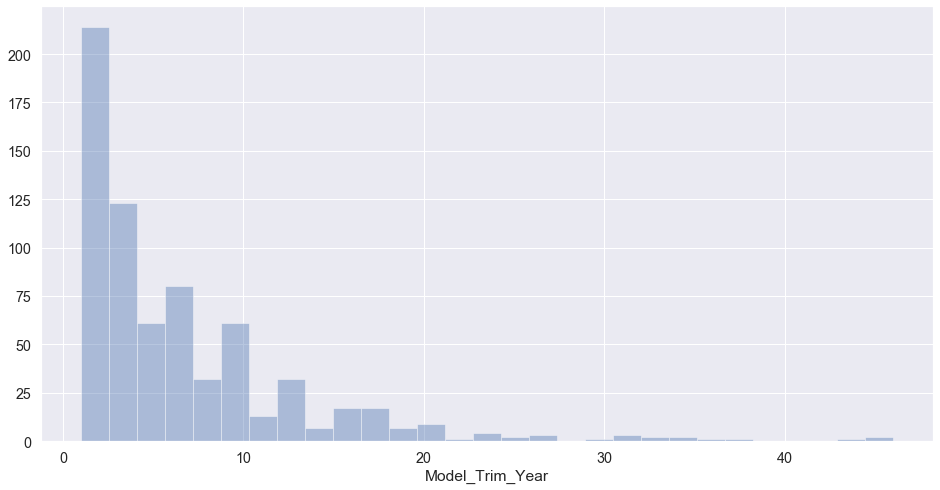

In [46]:
#Model_Trim_Year has rare categories, so target encoding will need regularization.
print(f"There are {len(vehicle['Model_Trim_Year'].value_counts())} unique Model_Trim_Year combos.  High cardinality.")
plt.figure(figsize=(16,8))
sns.set(font_scale=1.3)
sns.distplot(vehicle['Model_Trim_Year'].value_counts(), kde=False)
plt.show()

In [47]:
pd.set_option('max_colwidth', 100)
vehicle.loc[(vehicle['Year'] == 2015) & (vehicle['Price'] > 55_000)]

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN,displ,CombMPG,DownFlag,Model_Trim,Model_Trim_Year


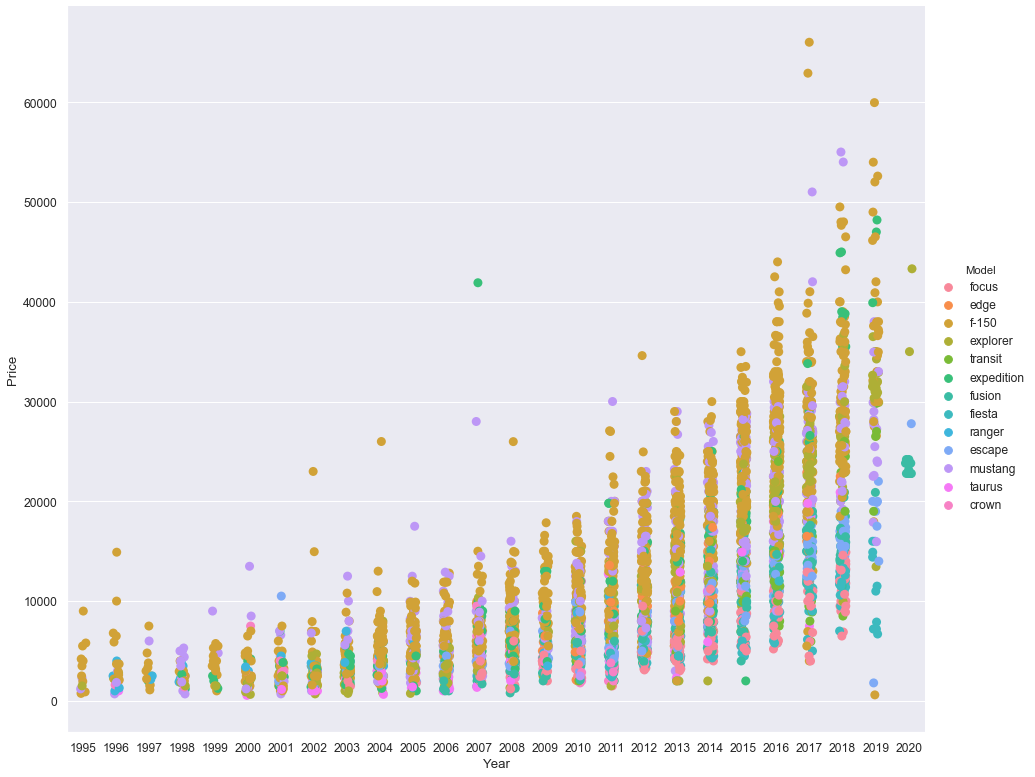

In [48]:
#Catplot by Year, Price, and Model.  Looks like Year^2 could be a good feature!
sns.set(font_scale=1.1)
sns.catplot(x='Year',y='Price',hue='Model', data=vehicle, height=11, aspect=1.2, s=9)  #s changes marker size
plt.show()

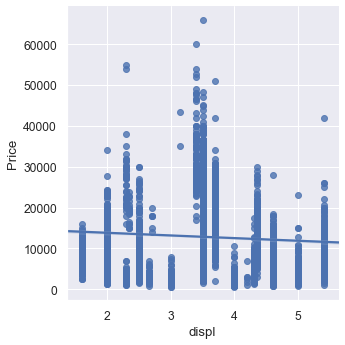

In [49]:
#Scatter by Displacement vs Price, and Model.
sns.set(font_scale=1.1)
sns.lmplot(x='displ',y='Price',data=vehicle)  #s changes marker size
plt.show()

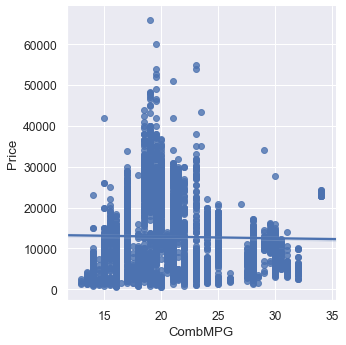

In [50]:
#Scatter by MPG vs Price.
sns.set(font_scale=1.1)
sns.lmplot(x='CombMPG',y='Price',data=vehicle)  #s changes marker size
plt.show()

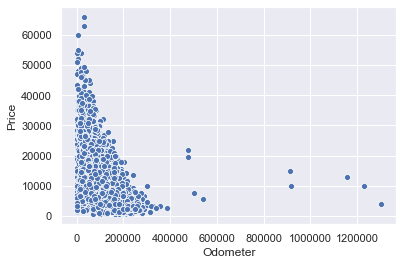

In [51]:
#Scatter by Odometer vs Price.  Will drop mileages over 400K.
sns.set(font_scale=1.0)
sns.scatterplot(x='Odometer',y='Price',data=vehicle)  #s changes marker size
plt.show()

In [52]:
#**** Drop outliers ****

#15627 price incorrect from typo. Mileages over 400K will be dropped.
drop_indices = [15627]
print(f'Drop {len(drop_indices)} outliers:', drop_indices)
vehicle = vehicle.drop(index = drop_indices)

Drop 1 outliers: [15627]


## Get stratified train and test

In [53]:
#Build train and test from vehicle.  Stratify by Model_Trim.
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=22)
for train_index, test_index in sss.split(vehicle, vehicle['Model_Trim']):  #split indices as ilocs
    train = vehicle.iloc[train_index]
    test = vehicle.iloc[test_index]

In [54]:
np.sort(train_index)

array([   0,    1,    2, ..., 4620, 4622, 4623], dtype=int64)

In [55]:
#Drop irrelenvant columns.
irrel_cols = ['URL_Vehicle', 'Title', 'Year_in_Title', 'RawMake', 'Make', 'SubLoc', 'Body', 'AttribDictionary', 
                    'ImageDictionary', 'VehicleID', 'VIN', 'TrimAlternate', 'DownFlag']

train = train.drop(irrel_cols, axis='columns', errors='ignore')
test = test.drop(irrel_cols, axis='columns', errors='ignore')

In [56]:
train.isna().sum()

Location             0
Year                 0
Odometer           609
Model                0
Trim                 0
Seller               0
Price                0
displ              360
CombMPG            360
Model_Trim           0
Model_Trim_Year      0
dtype: int64

In [57]:
#Show missing displ and CombMPG. F-250 is missing data after 1999.  Manually added 2017 data.
pd.options.display.max_rows = 500
train.groupby(['Model','Year']).agg({'displ' : 'median','CombMPG' : 'median'})

displ  CombMPG
Model      Year                
crown      1996   4.60     18.0
           1998   4.60     17.5
           2000   4.60     16.0
           2001   4.60     17.0
           2002   4.60     16.0
           2003   4.60     16.0
           2004   4.60     16.0
           2005   4.60     17.5
           2006   4.60     18.0
           2007   4.60     18.0
           2008   4.60     18.0
           2009   4.60     19.0
           2010   4.60     19.0
           2011   4.60     19.0
edge       2007   3.50     18.5
           2008   3.50     18.5
           2009   3.50     18.5
           2010   3.50     19.5
           2011   3.50     20.5
           2012   3.50     21.0
           2013   3.50     20.5
           2014   3.50     21.0
           2015   2.70     21.0
           2016   2.35     22.0
           2017   2.35     21.5
escape     2001   2.50     19.5
           2002   2.50     20.0
           2003   2.50     20.0
           2004   3.00     19.0
           2005   2.30     21.0
           2006   2.30     21.0
           2007   2.30     21.5
           2008   2.30     22.0
           2009   2.50     23.0
           2010   2.50     23.0
           2011   2.50     23.0
           2012   2.50     23.0
           2013   2.00     25.0
           2014   2.00     25.0
           2015   2.00     25.0
           2016   2.00     25.0
           2017   2.00     24.0
           2018   2.00     24.0
           2019   2.00     24.0
           2020   2.00     30.0
expedition 1997   5.00     14.0
           1998   5.00     13.5
           1999   5.00     13.0
           2000   5.00     13.5
           2001   5.00     14.0
           2002   5.00     13.5
           2003   5.00     14.0
           2004   5.00     14.0
           2005   5.40     14.0
           2006   5.40     14.0
           2007   5.40     15.0
           2008   5.40     14.0
           2009   5.40     16.0
           2010   5.40     15.0
           2011   5.40     15.0
           2012   5.40     15.5
           2013   5.40     15.5
           2014   5.40     15.5
           2015   3.50     17.0
           2016   3.50     17.0
           2017   3.50     17.0
           2018   3.50     19.0
           2019   3.50     19.0
explorer   1995   4.00     16.5
           1996   4.00     15.5
           1998   4.00     15.5
           1999   4.00     15.5
           2000   4.00     16.0
           2001   4.00     16.0
           2002   4.00     16.0
           2003   4.00     16.0
           2004   4.00     16.0
           2005   4.00     15.0
           2006   4.30     15.0
           2007   4.30     15.0
           2008   4.30     15.5
           2009   4.30     16.0
           2010   4.30     16.0
           2011   3.50     19.5
           2012   3.50     20.0
           2013   3.50     19.5
           2014   3.50     19.5
           2015   3.50     19.5
           2016   3.50     20.0
           2017   3.50     20.0
           2018   3.50     20.0
           2019   3.50     20.0
           2020   3.15     23.5
f-150      1995   5.00     14.0
           1996   5.00     14.0
           1997   4.60     15.5
           1998   4.60     15.0
           1999   4.60     14.0
           2000   4.60     15.0
           2001   5.00     14.5
           2002   5.00     14.0
           2003   5.00     15.0
           2004   5.40     15.0
           2005   4.60     15.0
           2006   5.00     15.0
           2007   5.40     15.0
           2008   5.40     15.0
           2009   4.60     16.0
           2010   4.60     16.0
           2011   3.70     17.0
           2012   3.70     17.0
           2013   3.70     17.0
           2014   3.70     17.0
           2015   3.50     19.5
           2016   3.50     18.5
           2017   3.50     19.0
           2018   3.40     19.0
           2019   3.40     19.5
fiesta     2011   1.60     32.0
           2012   1.60     32.0
           2013   1.60     32.0
           2014   1.60     30.0
           2015   1.60     30.0
           2016  

In [58]:
#Convert categories to numbers - Target Encode features with train Price.

from category_encoders.target_encoder import TargetEncoder
encode_cols = ['Location', 'Model', 'Trim', 'Seller', 'Model_Trim', 'Model_Trim_Year']

def target_encode_categorical(train, test, target, encoder):
    '''Returns encoded categorical features.  Encoded feature is a blend of
    (1) ExpectedVal( trainTarget | FeatureClass) and (2) "Prior": ExpectedVal(Target)
    over all training data.  Set testTarget to NaN to stop leakage. 
    
    Encoder smoothing balances Class average vs Prior. Higher smoothing is stronger
    regularization.
    
    Arguments
    ---------
    train: training data including target Y
    test: test data including target Y
    target: target Y
    encoder: TargetEncoder(cols_to encode, smoothing_float_value).  
    See https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html
    for more hyperparameters.'''
    trn=train.copy()
    tst=test.copy()
    if target in tst.columns:   #Omit any test targets from encoding.  Prevents leakage.
        tst[target] = np.nan  
    fullX = trn.append(tst)
    fullY = fullX.pop(target)       
    fullX_enc = encoder.fit_transform(fullX, fullY)
    
    #Overwrite train/test features with encoded features.
    train[encode_cols] = fullX_enc.loc[train.index, encode_cols]
    test[encode_cols] = fullX_enc.loc[test.index, encode_cols]
    return train, test        
    
train, test=target_encode_categorical(train,test,'Price',TargetEncoder(cols=encode_cols, min_samples_leaf=5, smoothing=2))

In [59]:
#Impute missing values - displ, CombMPG, odometer - by regressing on all other features.
def multivar_impute(train, test, target):
    '''Impute values with regression on numeric columns, excluding
    the target. Returns DataFrames.'''
    
    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute import IterativeImputer
    num_cols_ex_targ = train.select_dtypes(exclude='object').columns.tolist()
    num_cols_ex_targ.remove(target)
    
    #Get imputed dfs.
    ii = IterativeImputer(max_iter=10, random_state=3)
    train_impX = pd.DataFrame(ii.fit_transform(train[num_cols_ex_targ]), index=train.index, columns=num_cols_ex_targ)
    test_impX = pd.DataFrame(ii.transform(test[num_cols_ex_targ]), index=test.index, columns=num_cols_ex_targ)

    #Overwrite original features with imputed features.
    train[num_cols_ex_targ] = train_impX
    test[num_cols_ex_targ] = test_impX
    return train, test

train, test = multivar_impute(train, test,'Price')

In [60]:
#Drop understated odometer values.
filt_used_under_1K = (train['Odometer'] < 1000) & (train['Year'] < 2020)
drop_indices = train[filt_used_under_1K].index
print(f'Drop {len(drop_indices)} incorrect low mileage from train:', drop_indices)
train = train.drop(index = drop_indices, errors = 'ignore')

filt_used_under_1K = (test['Odometer'] < 1000) & (test['Year'] < 2020)
drop_indices = test[filt_used_under_1K].index
print(f'Drop {len(drop_indices)} incorrect low mileage from test:', drop_indices)
test = test.drop(index = drop_indices, errors = 'ignore')

#Drop anomaly odometer values.
filt_over_1M = train['Odometer'] > 400_000
drop_indices = train[filt_over_1M].index
print(f'Drop {len(drop_indices)} incorrect high mileage from train:', drop_indices)
train = train.drop(index = drop_indices, errors = 'ignore')

filt_over_1M = test['Odometer'] > 400_000
drop_indices = test[filt_over_1M].index
print(f'Drop {len(drop_indices)} incorrect high mileage from test:', drop_indices)
test = test.drop(index = drop_indices, errors = 'ignore')

Drop 45 incorrect low mileage from train: Int64Index([ 8106, 12497,  7150,   786,  1537,  3796, 11508,  8733,  8463,
             8466, 11488,    16, 15858,  5883,   827,  1531,  8121,  3631,
             7953, 11485,  4039,  1321,  7128, 11486,  6054, 12486,  7145,
             7851,  5473,  3409,  5157, 10803,  1533,  2951, 15809,  9151,
            12118, 15862,  5470, 14130, 12066,  8807,  3081, 11487, 13552],
           dtype='int64')
Drop 7 incorrect low mileage from test: Int64Index([18603, 7707, 4359, 10017, 3276, 14929, 17575], dtype='int64')
Drop 9 incorrect high mileage from train: Int64Index([12799, 4601, 2605, 1932, 10445, 15985, 15109, 7853, 12270], dtype='int64')
Drop 0 incorrect high mileage from test: Int64Index([], dtype='int64')


In [61]:
#Engineer features Part 2.
def get_polyfeatures(train, target, numer_cols, degree=2):
    '''
    Returns top train feature correlations as DataFrame.
    '''
    from sklearn.preprocessing import PolynomialFeatures
    poly=PolynomialFeatures(degree=degree, interaction_only=False, include_bias=False)    
    ptrn = train[numer_cols].copy()
    orig_cols = set(ptrn.columns.values)
    ptrn=pd.DataFrame(data=poly.fit_transform(ptrn),index=train.index,columns=poly.get_feature_names(input_features=numer_cols))
    final_cols = set(ptrn.columns.values)
    added_cols = final_cols - orig_cols
    print('Poly columns:', added_cols, '\n')
            
    #Get top correlation dataframe and top features list. 
    corrList = [[c, np.corrcoef(ptrn[c].values, train[target].values)[1,0]] for c in ptrn.columns]
    corrtrn=pd.DataFrame(data=corrList, columns=['feature','PriceCorr']).sort_values(by='PriceCorr', ascending=False).dropna().reset_index(drop=True)
    print('train correlations:\n\n', corrtrn)
    return ptrn[added_cols]  

num_feat=[col for col in train.select_dtypes(exclude='object').columns];
num_feat.remove('Price');

#Get poly feature dataframe.
p_added = get_polyfeatures(train=train, target='Price', numer_cols=num_feat, degree=2)

Poly columns: {'Odometer Model_Trim_Year', 'Seller Model_Trim', 'Trim Model_Trim_Year', 'Location Trim', 'Location^2', 'Model Seller', 'Location Model_Trim', 'Odometer Trim', 'Trim^2', 'Model^2', 'Model_Trim^2', 'Seller Model_Trim_Year', 'Year^2', 'Trim CombMPG', 'CombMPG Model_Trim', 'Location displ', 'Odometer Model', 'displ^2', 'Odometer displ', 'Location Odometer', 'Year CombMPG', 'Location Model', 'displ Model_Trim', 'Odometer CombMPG', 'Odometer^2', 'Location CombMPG', 'CombMPG^2', 'Location Seller', 'Year Model', 'CombMPG Model_Trim_Year', 'Location Model_Trim_Year', 'Model Model_Trim_Year', 'Model Model_Trim', 'Year Model_Trim', 'Odometer Seller', 'Year displ', 'Trim Seller', 'Year Odometer', 'Seller CombMPG', 'Seller displ', 'Model Trim', 'displ Model_Trim_Year', 'Odometer Model_Trim', 'Seller^2', 'Model_Trim Model_Trim_Year', 'Location Year', 'Trim displ', 'Year Trim', 'Trim Model_Trim', 'Model CombMPG', 'Model displ', 'Year Model_Trim_Year', 'displ CombMPG', 'Model_Trim_Year

In [62]:
train.head(2)

,Location,Year,Odometer,Model,Trim,Seller,Price,displ,CombMPG,Model_Trim,Model_Trim_Year
6803,13160.614754,2009.0,145887.995628,16083.901276,22104.494118,7846.639162,8250.0,4.128084,18.072878,22104.494118,12844.098053
15677,9238.128514,2017.0,77052.995061,7328.130952,10060.275261,15741.258162,3995.0,2.000000,29.000000,8154.535398,10658.592487


In [63]:
#Part 3. Engineer pair features.

#Squared feature.    
for elem in ['Year']:
    print(elem + '^2')
    train[elem + '^2'] = train[elem]**2
    test[elem + '^2'] = test[elem]**2

#Drop features.    
for c in ['Location','Model', 'Trim', 'Year', 'Model_Trim']:
    train.drop(columns=c, inplace=True)
    test.drop(columns=c, inplace=True)

Year^2


In [64]:
train.head(2)

,Odometer,Seller,Price,displ,CombMPG,Model_Trim_Year,Year^2
6803,145887.995628,7846.639162,8250.0,4.128084,18.072878,12844.098053,4036081.0
15677,77052.995061,15741.258162,3995.0,2.000000,29.000000,10658.592487,4068289.0


### Correlation Heatmap

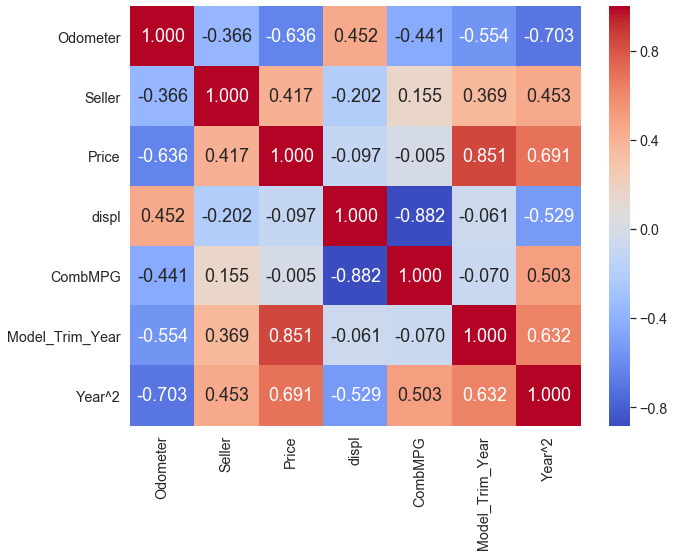

In [65]:
#Show correlation heatmap.  Keeping the collinear features may help prediction, while making the 
#linear regression coefficients less interpretable.
plt.figure(figsize=(10,8))
sns.set(font_scale=1.3)
sns.heatmap(train.corr(), cmap='coolwarm', annot=True, annot_kws={"size": 18}, fmt=".3f")
plt.tight_layout()

In [66]:
# #Investigate outliers revealed in pairplot.
# sns.set(font_scale=1.3)
# sns.pairplot(train)
# plt.show()

In [67]:
vehicle.Model_Trim.value_counts()

f-150_None               362
focus_se                 251
f-150_xlt                244
fusion_se                192
explorer_xlt             190
mustang_None             183
mustang_gt               179
f-150_xltsupercrew       164
f-150_lariat             146
f-150_supercrew          134
fusion_None              126
escape_None              126
focus_None               122
f-150_xl                 108
escape_se                104
expedition_xlt           103
explorer_limited         100
mustang_gtpremium         96
f-150_supercrewxlt        96
f-150_xlt4x4              95
fiesta_se                 90
explorer_None             86
expedition_None           84
edge_sel                  83
f-150_4x4                 77
f-150_lariat4x4           73
expedition_limited        64
transit_connect           64
expedition_eddie          63
f-150_lariatsupercrew     58
explorer_sport            57
taurus_None               56
f-150_fx4                 53
mustang_convertible       51
crown_None    

### Save Preprocessed data - train and test

In [68]:
#Save tables to PostgreSQL database.
import psycopg2
from sqlalchemy import create_engine
from sqlalchemy.dialects.postgresql import JSON, JSONB
engine=create_engine("postgresql://postgres@localhost:5432/postgres")

#Write vehicle table with json
vehicle.to_sql(name='vehicle', con=engine, if_exists='replace', index=True,\
               dtype={'AttribDictionary': JSONB, 'ImageDictionary': JSONB})

#Write train and test
train.to_sql(name='trainClean', con=engine, if_exists='replace', index=True)
test.to_sql(name='testClean', con=engine, if_exists='replace', index=True)

In [69]:
print('train shape:', train.shape, '| test shape:', test.shape)

train shape: (4107, 7) | test shape: (456, 7)


In [70]:
vehicle.shape

(4624, 23)